### 1. Kütüphanelerin İndirilmesi

In [ ]:
import torch 
import torchvision 
from torchvision import transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import nn.functional as F
import random

In [149]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device}")

You are using cuda


### 2. Veri Setinin Hazırlanması

In [155]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
train_data = torchvision.datasets.MNIST(
    root = "./data",
    train = True,
    transform = transforms
) 

test_data = torchvision.datasets.MNIST(
    root = "./data",
    train = False,
    transform = transforms
)

In [157]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [162]:
rand_num = random.randint(0, len(train_data))
train_img, train_label = train_data[rand_num]
train_img.shape, train_label

(torch.Size([1, 32, 32]), 7)

Text(0.5, 1.0, '7')

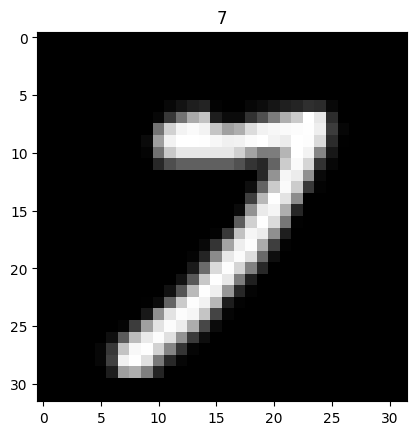

In [164]:
plt.imshow(train_img.permute(1,2,0), cmap = "gray")
plt.title(train_label)

### 3. DataLoader Oluşturulması

In [ ]:
train_loader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle = False
)

### 4. Model Mimarisinin Oluşturulması
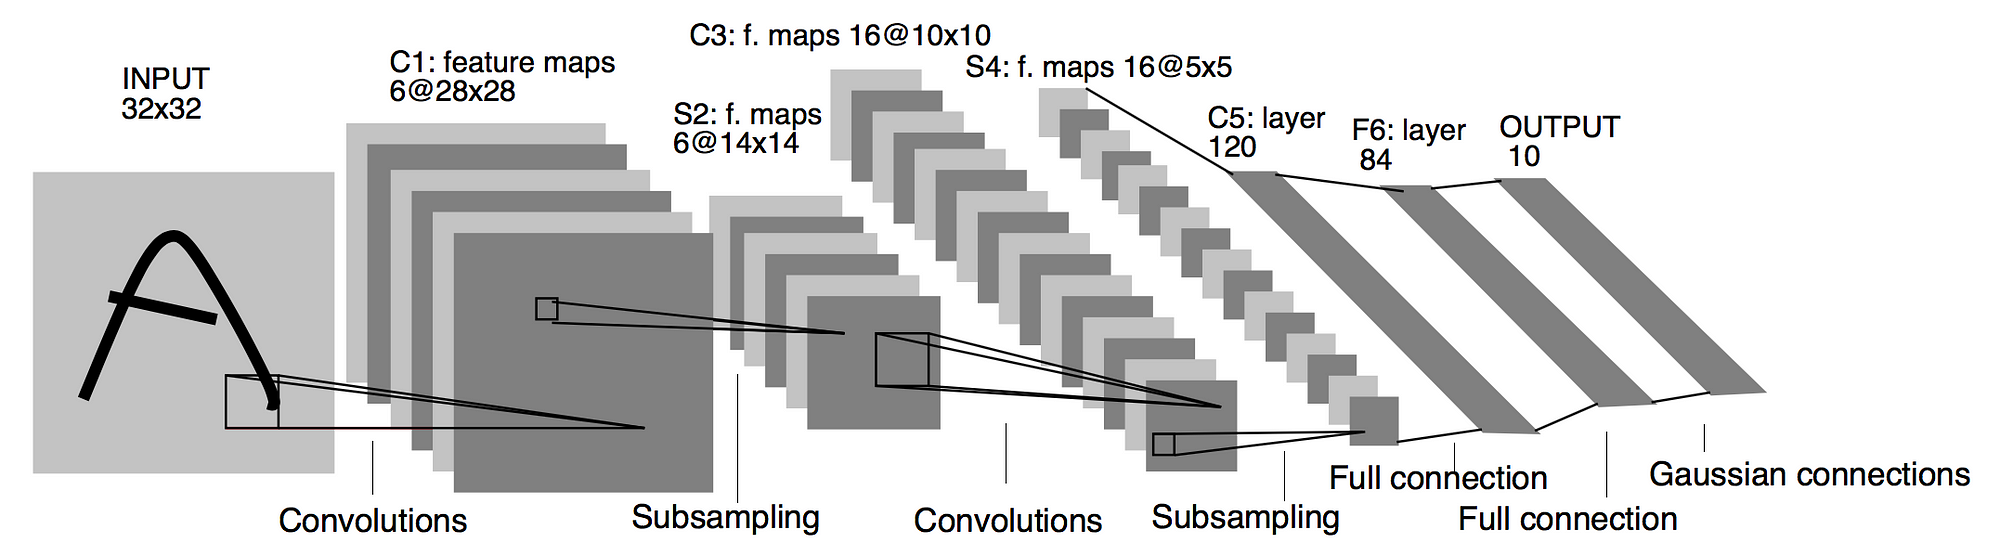

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #6x28x28
        self.conv1 = nn.Conv2d(in_channels = 1, kernel_size = (5,5), stride = 1, padding = 0, out_channels = 6)
        #6x14x14
        self.pool1 = nn.AvgPool2d(2,2)
        #16x10x10
        self.conv2 = nn.Conv2d(in_channels = 6, kernel_size = (5,5), stride = 1, padding = 0, out_channels = 16)
        #16x5x5
        self.pool2 = nn.AvgPool2d(2,2) 
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [167]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
noise = torch.randn(size = (1,1,28,28))
predictions = model(noise) 
print(predictions)

tensor([[-8.8643, -2.0853,  1.1123,  4.5371, -5.8428, -1.0742, -4.8124, -2.7709,
          0.1040, -8.4301]], grad_fn=<AddmmBackward0>)


In [169]:
model = model.to(device)

### 5. Training and Testing the Model
Makalede belirtildiği üzere MSE loss fonksiyonu ve tanh aktivasyon fonksiyonu kullanıldı. Normalde MSE loss CNN modellerinde kullanılmaz (Genelde GAN mimarisinde kullanılabilir.) Onun yerine CrossEntropyLoss kullanılır bu da Gradient Vanisihing problemini ortadan kaldırır. Bu çalışmada Adam optimizer kullanılmıştır. Orijinal çalışmada ise Gradient Descent kullanılmıştır.

In [170]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3) 
loss = nn.MSELoss()

In [ ]:
def train(dataloader, model, loss_fn, op_fn):
  size = len(dataloader.dataset)
  for batch, (x,y) in enumerate(dataloader): 
      y_pred = model(x) 
      y_onehot = F.one_hot(y, num_classes=10).float()
      y_onehot = y_onehot.to(device)
      loss = loss_fn(y_pred, y) 

      op_fn.zero_grad()
      loss.backward()
      op_fn.step()

      if batch % 100 ==0:
          loss, current = loss.item(), batch * len(x) 
          print(f"loss is {loss}  [{current} / {size}]")

In [ ]:
def test(training_dataloader, model, loss_fn):
    size = len(training_dataloader.dataset)
    num_batches = len(training_dataloader) 
    correct, test_loss = 0,0 
    with torch.no_grad():
        for x,y in training_dataloader:
            y_pred = model(x) 
            test_loss += loss_fn(y_pred, y).item() 
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item() 
    test_loss /= num_batches 
    correct /= size 
    accuracy = correct*100
    print(f"accuracy is {correct*100} test_loss is {test_loss}")
    return accuracy, test_loss

In [ ]:
EPOCHS = 20 
acc = []
test_loss = []
for epochs in range(EPOCHS):
  print(f"epoch: {epochs+1} ---------------------------")
  train(train_loader, model, loss, optim)
  accuracy, loss = test(test_loader, model, loss) 
  acc.append(accuracy)
  test_loss.append(loss)

epoch: 1 ---------------------------
loss is 0.06919246166944504  [0 / 60000]
loss is 0.03250034153461456  [6400 / 60000]
loss is 0.0011418398935347795  [12800 / 60000]
loss is 0.019529595971107483  [19200 / 60000]
loss is 0.00032802592613734305  [25600 / 60000]
loss is 0.010714688338339329  [32000 / 60000]
loss is 8.012681792024523e-05  [38400 / 60000]
loss is 0.0004946717526763678  [44800 / 60000]
loss is 0.0196064542979002  [51200 / 60000]
loss is 0.0046088434755802155  [57600 / 60000]
accuracy is 98.94 test_loss is 0.044030290242882325
epoch: 2 ---------------------------
loss is 0.0006330295000225306  [0 / 60000]
loss is 0.0012735201744362712  [6400 / 60000]
loss is 0.001107457559555769  [12800 / 60000]
loss is 0.008691473864018917  [19200 / 60000]
loss is 8.129572233883664e-05  [25600 / 60000]
loss is 0.023828454315662384  [32000 / 60000]
loss is 0.00034491921542212367  [38400 / 60000]
loss is 0.07409269362688065  [44800 / 60000]
loss is 8.558714034734294e-05  [51200 / 60000]
los